In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data


In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(221)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import math
import prediction_prep as prep

import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [4]:
# READ IN ALL DATA
ticker = 'TSLA'
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
# fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\TSLA_2021.csv')
fin_data = pd.read_csv('stock_data/{}_2021.csv'.format(ticker))

# Call custom function to get concatenated df with all features
df = prep.get_regression_df(ticker_name = str.lower(ticker),
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)

# Set up a results dictionary object
results_dict = {}

df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,0.0,2.0,2.0,99.995000,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,253.0,49.0,302.0,16.225160,0,253.0,126.5,NaN,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,149.0,21.0,170.0,12.352934,0,402.0,201.0,100.000000,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,130.0,24.0,154.0,15.584405,0,279.0,139.5,-48.616601,45.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.127668,0,0.755027
4,2021-01-05,162.0,27.0,189.0,14.285707,0,292.0,146.0,8.724832,51.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.403968,1,-0.906421


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int64         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     341 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOSE PRICE WITH SENTIMENT

### 1-Day Shift

In [6]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['7D%Change', 'Volume', 'High', '7Dir', 'Dir', '6Dir', '3D%Change', '6D%Change', 'Low', 'SD', 'Daily%Change', '5Dir', '2Dir', 'Open', '2D%Change', '5D%Change', '4Dir', '4D%Change', 'SD_log', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,5Dir(t-1),2Dir(t-1),Open(t-1),2D%Change(t-1),5D%Change(t-1),4Dir(t-1),4D%Change(t-1),SD_log(t-1),3Dir(t-1),Close(t-1)
7,854.409973,2,606.0,185.0,791.0,23.388113,1206.0,603.0,-75.355836,331.0,...,1.0,0.0,831.000000,-3.474923,15.552777,1.0,12.362764,0.893449,1.0,849.440002
8,845.000000,3,314.0,92.0,406.0,22.660093,920.0,460.0,-47.666667,277.0,...,1.0,1.0,852.760010,5.327971,13.020185,1.0,4.701975,-0.062028,0.0,854.409973
9,826.159973,4,311.0,42.0,353.0,11.898014,625.0,312.5,-48.679868,134.0,...,1.0,0.0,843.390015,-0.522698,3.548848,0.0,-3.979457,-0.293989,1.0,845.000000
10,844.549988,1,121.0,36.0,157.0,22.929922,123.0,61.5,572.222222,43.0,...,0.0,0.0,852.000000,-3.306375,-6.120321,1.0,1.845433,-0.574965,0.0,826.159973
11,850.450012,2,30.0,8.0,38.0,21.052576,151.0,75.5,1400.000000,44.0,...,1.0,0.0,837.799988,-0.053256,4.112475,0.0,-0.575675,-0.372200,0.0,844.549988


In [7]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,2Dir(t-1),Open(t-1),2D%Change(t-1),5D%Change(t-1),4Dir(t-1),4D%Change(t-1),SD_log(t-1),3Dir(t-1),Close(t-1),Prediction
236,1003.799988,3,230.0,23.0,253.0,9.090905,366.0,183.0,379.166667,52.0,...,1.0,1052.709961,5.941462,-2.378086,0.0,-1.442008,0.024578,1.0,1068.959961,1003.799988
237,1017.030029,4,94.0,9.0,103.0,8.737856,324.0,162.0,-30.882353,32.0,...,0.0,1060.640015,-4.559069,-7.449750,0.0,-1.100523,-0.015458,0.0,1003.799988,1017.030029
238,966.409973,0,0.0,0.0,0.0,0.000000,16.0,8.0,-100.000000,4.0,...,0.0,1008.750000,-4.857987,0.202967,1.0,0.794840,-0.756003,0.0,1017.030029,966.409973
239,958.510010,1,3.0,1.0,4.0,24.999375,3.0,1.5,-81.250000,1.0,...,0.0,1001.090027,-3.724847,-4.221964,0.0,-8.114098,0.591333,0.0,966.409973,958.510010
240,975.989990,2,6.0,1.0,7.0,14.285510,9.0,4.5,100.000000,2.0,...,0.0,945.000000,-5.754011,-8.865224,0.0,-10.332468,0.248647,0.0,958.510010,975.989990


In [8]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(152, 100)
(44, 100)


In [9]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(145, 7, 100) (145,)
(37, 7, 100) (37,)
0.9928353439054023
0.9928353439054023


In [10]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.2286
Epoch 1: val_loss improved from inf to 0.58853, saving model to TSLA_Close_1shift_Sentiment.h5
10/10 [==============================] - 8s 384ms/step - loss: 0.2286 - val_loss: 0.5885
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0285
Epoch 2: val_loss improved from 0.58853 to 0.21246, saving model to TSLA_Close_1shift_Sentiment.h5
10/10 [==============================] - 3s 280ms/step - loss: 0.0285 - val_loss: 0.2125
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0109
Epoch 3: val_loss improved from 0.21246 to 0.08879, saving model to TSLA_Close_1shift_Sentiment.h5
10/10 [==============================] - 3s 277ms/step - loss: 0.0109 - val_loss: 0.0888
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0150
Epoch 4: val_loss did not improve from 0.08879
10/10 [==============================] - 3s 253ms/step - loss: 0.0150 - val_loss: 0.1656


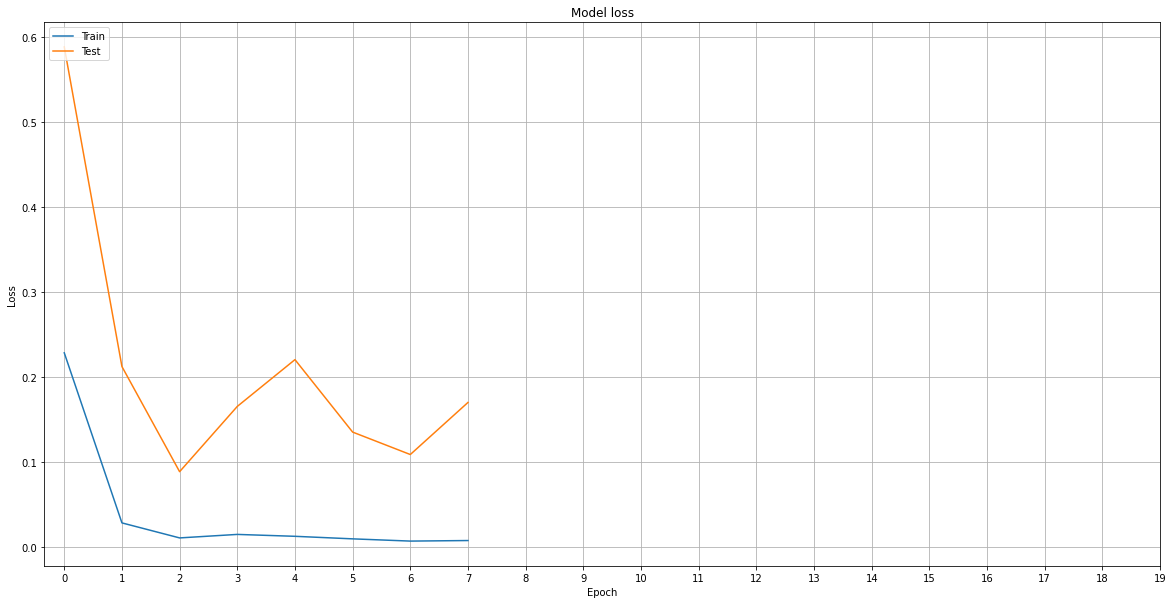

In [12]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [13]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list
results

Median Absolute Error (MAE): 79.51
Mean Absolute Percentage Error (MAPE): 7.35 %
Median Absolute Percentage Error (MDAPE): 6.84 %


,MAE,MAPE,MDAPE
0,79.51029,7.350353,6.840483


In [14]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

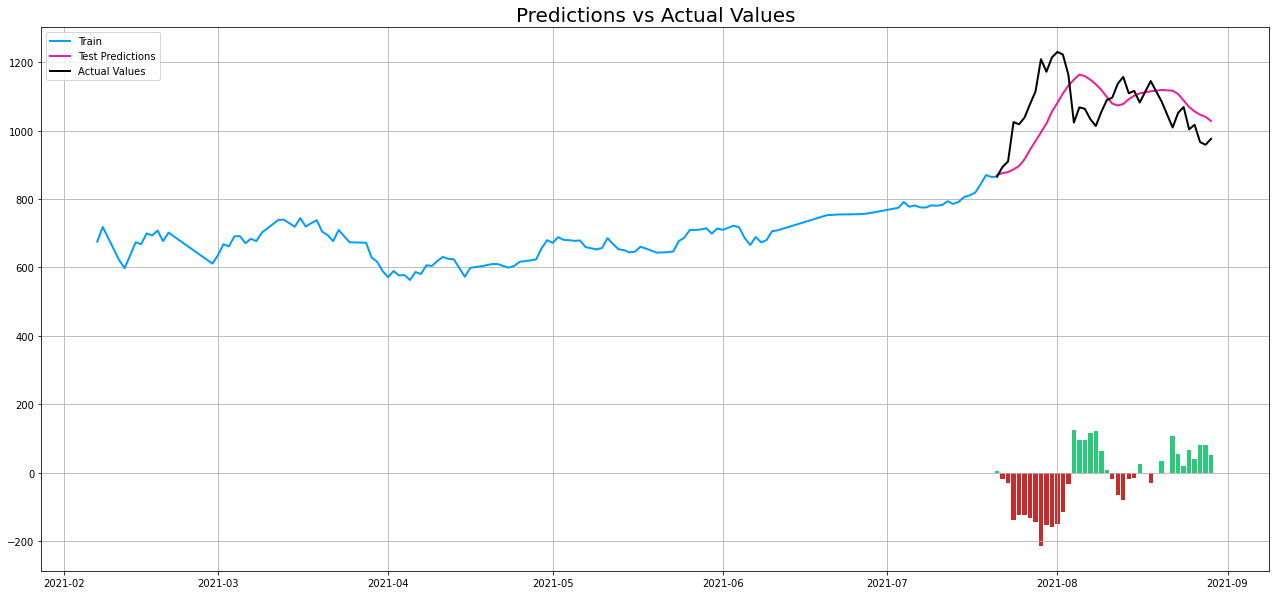

In [15]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 4-Day Shift

In [16]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['7D%Change', 'Volume', 'High', '7Dir', 'Dir', '6Dir', '3D%Change', '6D%Change', 'Low', 'SD', 'Daily%Change', '5Dir', '2Dir', 'Open', '2D%Change', '5D%Change', '4Dir', '4D%Change', 'SD_log', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,5Dir(t-4),2Dir(t-4),Open(t-4),2D%Change(t-4),5D%Change(t-4),4Dir(t-4),4D%Change(t-4),SD_log(t-4),3Dir(t-4),Close(t-4)
10,844.549988,1,46.0,19.0,65.0,29.230724,357.0,178.5,-85.350318,61.0,...,1.0,0.0,831.000000,-3.474923,15.552777,1.0,12.362764,0.893449,1.0,849.440002
11,850.450012,2,18.0,3.0,21.0,14.285646,64.0,32.0,-94.212219,22.0,...,1.0,1.0,852.760010,5.327971,13.020185,1.0,4.701975,-0.062028,0.0,854.409973
12,844.989990,3,2.0,7.0,9.0,77.776914,20.0,10.0,-95.652174,10.0,...,1.0,0.0,843.390015,-0.522698,3.548848,0.0,-3.979457,-0.293989,1.0,845.000000
13,846.640015,4,121.0,36.0,157.0,22.929922,123.0,61.5,572.222222,43.0,...,0.0,0.0,852.000000,-3.306375,-6.120321,1.0,1.845433,-0.574965,0.0,826.159973
14,880.799988,0,11.0,4.0,15.0,26.666489,23.0,11.5,-63.333333,6.0,...,1.0,0.0,837.799988,-0.053256,4.112475,0.0,-0.575675,-0.372200,0.0,844.549988


In [17]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-4)', 'comments_positive(t-4)', 'comment_count(t-4)', 'pct_pos_comments(t-4)', 'comments_neutral_rollsum_2D(t-4)', 'comments_neutral_rollmean_2D(t-4)', 'comments_neutral_2D_pctchg(t-4)', 'comments_positive_rollsum_2D(t-4)', 'comments_positive_rollmean_2D(t-4)', 'comments_positive_2D_pctchg(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'pct_pos_comments_rollsum_2D(t-4)', 'pct_pos_comments_rollmean_2D(t-4)', 'pct_pos_comments_2D_pctchg(t-4)', 'comments_neutral_rollsum_3D(t-4)', 'comments_neutral_rollmean_3D(t-4)', 'comments_neutral_3D_pctchg(t-4)', 'comments_positive_rollsum_3D(t-4)', 'comments_positive_rollmean_3D(t-4)', 'comments_positive_3D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'pct_pos_comments_rollsum_3D(t-4)', 'pct_pos_comments_rollmean_3D(t-4)', 'pct_pos_comments_3D_pctchg(t-4)', 'comments_ne

,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,2Dir(t-4),Open(t-4),2D%Change(t-4),5D%Change(t-4),4Dir(t-4),4D%Change(t-4),SD_log(t-4),3Dir(t-4),Close(t-4),Prediction
238,966.409973,0,94.0,9.0,103.0,8.737856,324.0,162.0,-30.882353,32.0,...,1.0,1044.199951,3.623755,-8.124848,0.0,-3.949772,0.495597,0.0,1051.750000,966.409973
239,958.510010,1,443.0,70.0,513.0,13.645222,537.0,268.5,92.608696,79.0,...,1.0,1052.709961,5.941462,-2.378086,0.0,-1.442008,0.024578,1.0,1068.959961,958.510010
240,975.989990,2,16.0,4.0,20.0,19.999900,459.0,229.5,-82.978723,74.0,...,0.0,1060.640015,-4.559069,-7.449750,0.0,-1.100523,-0.015458,0.0,1003.799988,975.989990
241,926.919983,3,0.0,0.0,0.0,0.000000,16.0,8.0,-100.000000,4.0,...,0.0,1008.750000,-4.857987,0.202967,1.0,0.794840,-0.756003,0.0,1017.030029,926.919983
242,932.570007,4,3.0,1.0,4.0,24.999375,3.0,1.5,-81.250000,1.0,...,0.0,1001.090027,-3.724847,-4.221964,0.0,-8.114098,0.591333,0.0,966.409973,932.570007


In [18]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(154, 100)
(45, 100)


In [19]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(147, 7, 100) (147,)
(38, 7, 100) (38,)
0.8511042826048196
0.8511042826048196


In [20]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.4567
Epoch 1: val_loss improved from inf to 0.36181, saving model to TSLA_Close_4shift_Sentiment.h5
10/10 [==============================] - 8s 397ms/step - loss: 0.4567 - val_loss: 0.3618
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0421
Epoch 2: val_loss improved from 0.36181 to 0.15690, saving model to TSLA_Close_4shift_Sentiment.h5
10/10 [==============================] - 3s 300ms/step - loss: 0.0421 - val_loss: 0.1569
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0260
Epoch 3: val_loss did not improve from 0.15690
10/10 [==============================] - 3s 278ms/step - loss: 0.0260 - val_loss: 0.2091
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0191
Epoch 4: val_loss did not improve from 0.15690
10/10 [==============================] - 3s 265ms/step - loss: 0.0191 - val_loss: 0.4657
Epoch 5/100
10/10 [==============================] -

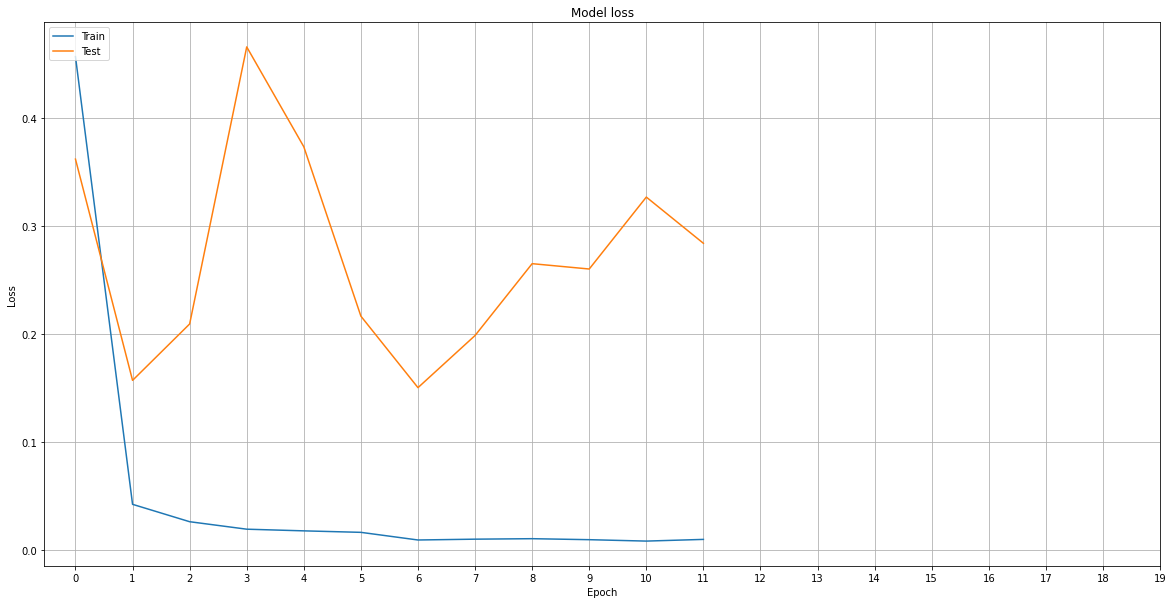

In [22]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 95.98
Mean Absolute Percentage Error (MAPE): 8.59 %
Median Absolute Percentage Error (MDAPE): 6.21 %


,MAE,MAPE,MDAPE
0,95.982795,8.592865,6.20888


In [24]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

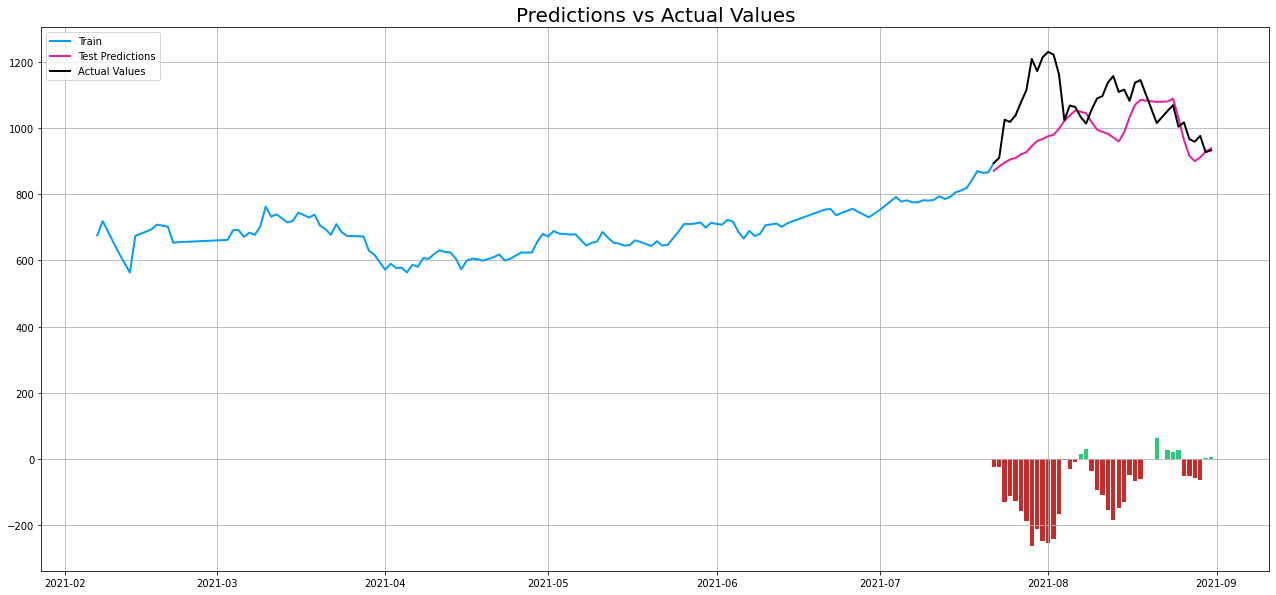

In [25]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 7-Day Shift

In [26]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['7D%Change', 'Volume', 'High', '7Dir', 'Dir', '6Dir', '3D%Change', '6D%Change', 'Low', 'SD', 'Daily%Change', '5Dir', '2Dir', 'Open', '2D%Change', '5D%Change', '4Dir', '4D%Change', 'SD_log', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,5Dir(t-7),2Dir(t-7),Open(t-7),2D%Change(t-7),5D%Change(t-7),4Dir(t-7),4D%Change(t-7),SD_log(t-7),3Dir(t-7),Close(t-7)
13,846.640015,4,46.0,19.0,65.0,29.230724,357.0,178.5,-85.350318,61.0,...,1.0,0.0,831.000000,-3.474923,15.552777,1.0,12.362764,0.893449,1.0,849.440002
14,880.799988,0,121.0,36.0,157.0,22.929922,123.0,61.5,572.222222,43.0,...,1.0,1.0,852.760010,5.327971,13.020185,1.0,4.701975,-0.062028,0.0,854.409973
15,883.090027,1,30.0,8.0,38.0,21.052576,151.0,75.5,1400.000000,44.0,...,1.0,0.0,843.390015,-0.522698,3.548848,0.0,-3.979457,-0.293989,1.0,845.000000
16,864.159973,2,12.0,2.0,14.0,14.285612,42.0,21.0,-90.082645,10.0,...,0.0,0.0,852.000000,-3.306375,-6.120321,1.0,1.845433,-0.574965,0.0,826.159973
17,835.429993,3,11.0,4.0,15.0,26.666489,23.0,11.5,-63.333333,6.0,...,1.0,0.0,837.799988,-0.053256,4.112475,0.0,-0.575675,-0.372200,0.0,844.549988


In [27]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-7)', 'comments_positive(t-7)', 'comment_count(t-7)', 'pct_pos_comments(t-7)', 'comments_neutral_rollsum_2D(t-7)', 'comments_neutral_rollmean_2D(t-7)', 'comments_neutral_2D_pctchg(t-7)', 'comments_positive_rollsum_2D(t-7)', 'comments_positive_rollmean_2D(t-7)', 'comments_positive_2D_pctchg(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'pct_pos_comments_rollsum_2D(t-7)', 'pct_pos_comments_rollmean_2D(t-7)', 'pct_pos_comments_2D_pctchg(t-7)', 'comments_neutral_rollsum_3D(t-7)', 'comments_neutral_rollmean_3D(t-7)', 'comments_neutral_3D_pctchg(t-7)', 'comments_positive_rollsum_3D(t-7)', 'comments_positive_rollmean_3D(t-7)', 'comments_positive_3D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'pct_pos_comments_rollsum_3D(t-7)', 'pct_pos_comments_rollmean_3D(t-7)', 'pct_pos_comments_3D_pctchg(t-7)', 'comments_ne

,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,2Dir(t-7),Open(t-7),2D%Change(t-7),5D%Change(t-7),4Dir(t-7),4D%Change(t-7),SD_log(t-7),3Dir(t-7),Close(t-7),Prediction
240,975.989990,2,230.0,23.0,253.0,9.090905,366.0,183.0,379.166667,52.0,...,0.0,1001.510010,-6.969387,-11.256034,0.0,-11.858381,0.436812,0.0,1009.010010,975.989990
241,926.919983,3,94.0,9.0,103.0,8.737856,324.0,162.0,-30.882353,32.0,...,1.0,1044.199951,3.623755,-8.124848,0.0,-3.949772,0.495597,0.0,1051.750000,926.919983
242,932.570007,4,443.0,70.0,513.0,13.645222,537.0,268.5,92.608696,79.0,...,1.0,1052.709961,5.941462,-2.378086,0.0,-1.442008,0.024578,1.0,1068.959961,932.570007
243,899.940002,0,3.0,1.0,4.0,24.999375,3.0,1.5,-81.250000,1.0,...,0.0,1060.640015,-4.559069,-7.449750,0.0,-1.100523,-0.015458,0.0,1003.799988,899.940002
244,938.530029,1,6.0,1.0,7.0,14.285510,9.0,4.5,100.000000,2.0,...,0.0,1008.750000,-4.857987,0.202967,1.0,0.794840,-0.756003,0.0,1017.030029,938.530029


In [28]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(156, 100)
(45, 100)


In [29]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(149, 7, 100) (149,)
(38, 7, 100) (38,)
0.670416082804633
0.670416082804633


In [30]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.7262
Epoch 1: val_loss improved from inf to 0.14359, saving model to TSLA_Close_7shift_Sentiment.h5
10/10 [==============================] - 8s 421ms/step - loss: 0.7262 - val_loss: 0.1436
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0485
Epoch 2: val_loss did not improve from 0.14359
10/10 [==============================] - 3s 292ms/step - loss: 0.0485 - val_loss: 0.3029
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0256
Epoch 3: val_loss did not improve from 0.14359
10/10 [==============================] - 3s 289ms/step - loss: 0.0256 - val_loss: 0.2926
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0176
Epoch 4: val_loss did not improve from 0.14359
10/10 [==============================] - 3s 277ms/step - loss: 0.0176 - val_loss: 0.1552
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.0116
Epoch 5: val_loss did not im

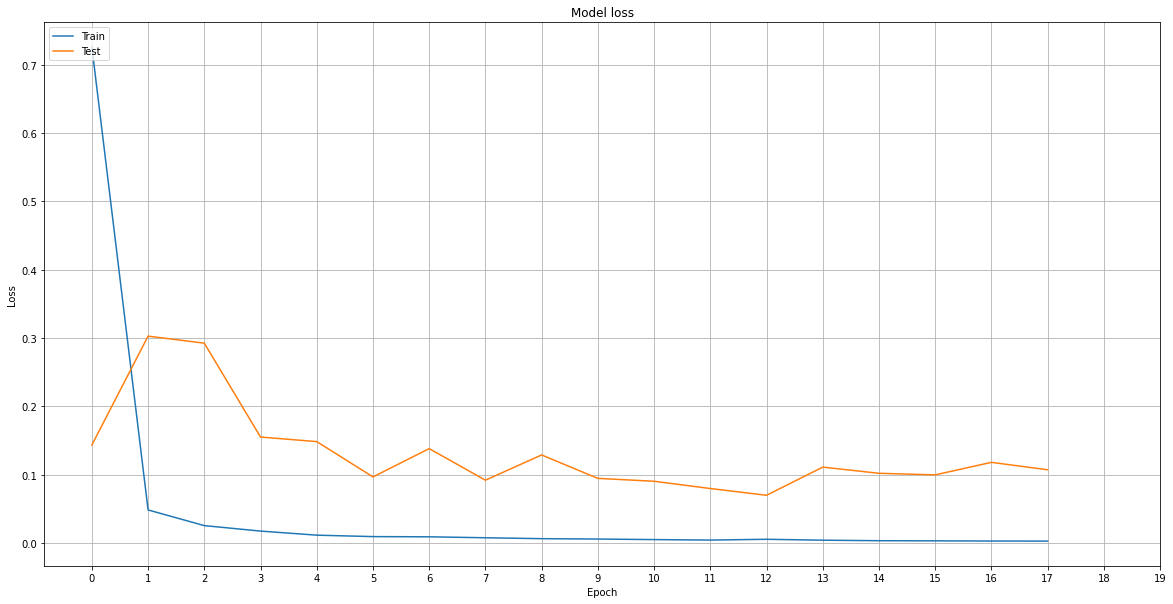

In [32]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 92.59
Mean Absolute Percentage Error (MAPE): 8.33 %
Median Absolute Percentage Error (MDAPE): 5.83 %


,MAE,MAPE,MDAPE
0,92.590979,8.326711,5.825877


In [34]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

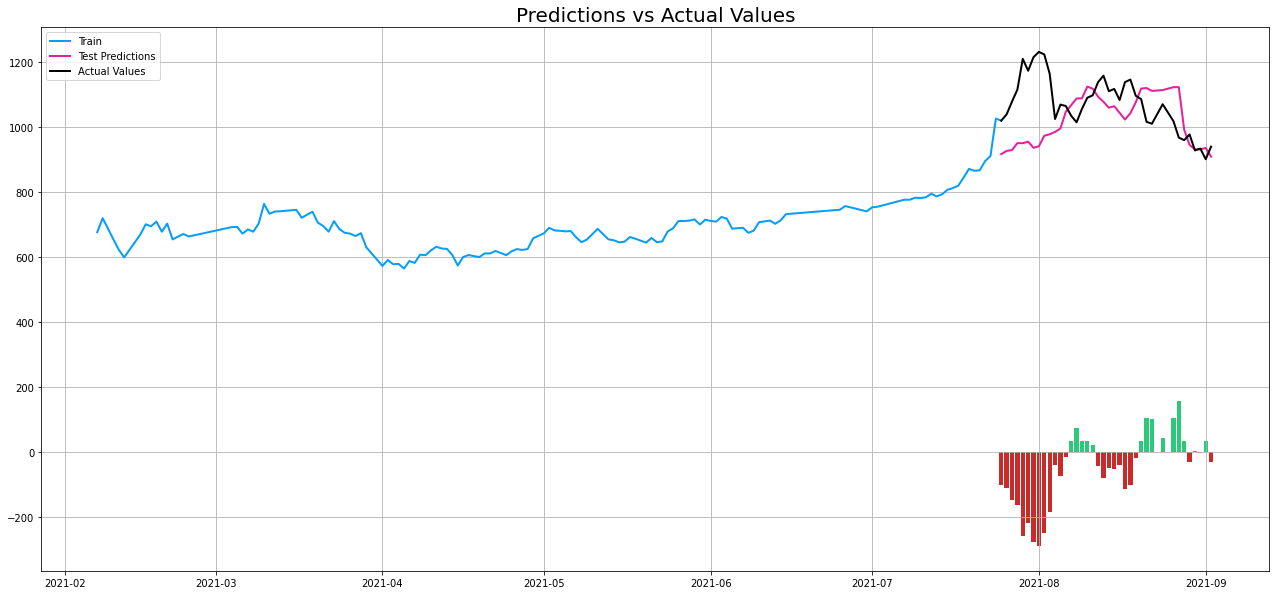

In [35]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: CLOSE PRICE WITHOUT SENTIMENT

### 1-Day Shift

In [36]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['7D%Change', 'Volume', 'High', '7Dir', 'Dir', '6Dir', '3D%Change', '6D%Change', 'Low', 'SD', 'Daily%Change', '5Dir', '2Dir', 'Open', '2D%Change', '5D%Change', '4Dir', '4D%Change', 'SD_log', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,5Dir(t-1),2Dir(t-1),Open(t-1),2D%Change(t-1),5D%Change(t-1),4Dir(t-1),4D%Change(t-1),SD_log(t-1),3Dir(t-1),Close(t-1)
7,854.409973,2,791.0,1537.0,768.5,-72.572816,4421.0,1473.666667,-63.914234,6613.0,...,1.0,0.0,831.000000,-3.474923,15.552777,1.0,12.362764,0.893449,1.0,849.440002
8,845.000000,3,406.0,1197.0,598.5,-45.576408,1943.0,647.666667,-85.922330,4827.0,...,1.0,1.0,852.760010,5.327971,13.020185,1.0,4.701975,-0.062028,0.0,854.409973
9,826.159973,4,353.0,759.0,379.5,-55.372946,1550.0,516.666667,-52.680965,2296.0,...,1.0,0.0,843.390015,-0.522698,3.548848,0.0,-3.979457,-0.293989,1.0,845.000000
10,844.549988,1,157.0,166.0,83.0,647.619048,187.0,62.333333,141.538462,252.0,...,0.0,0.0,852.000000,-3.306375,-6.120321,1.0,1.845433,-0.574965,0.0,826.159973
11,850.450012,2,38.0,195.0,97.5,322.222222,204.0,68.000000,80.952381,225.0,...,1.0,0.0,837.799988,-0.053256,4.112475,0.0,-0.575675,-0.372200,0.0,844.549988


In [37]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,2Dir(t-1),Open(t-1),2D%Change(t-1),5D%Change(t-1),4Dir(t-1),4D%Change(t-1),SD_log(t-1),3Dir(t-1),Close(t-1),Prediction
243,899.940002,0,1.0,1.0,0.5,-85.714286,8.0,2.666667,-88.888889,17.0,...,0.0,914.770020,-4.448814,-8.304575,0.0,-3.501616,0.267310,0.0,932.570007,899.940002
244,938.530029,1,1.0,2.0,1.0,100.000000,2.0,0.666667,-85.714286,9.0,...,0.0,910.700012,-2.910713,-6.878030,0.0,-6.110526,0.065025,0.0,899.940002,938.530029
245,1008.869995,2,3.0,4.0,2.0,200.000000,5.0,1.666667,100.000000,5.0,...,1.0,916.869995,0.639096,-2.084483,0.0,-3.838150,-0.304254,1.0,938.530029,1008.869995
246,1067.000000,3,6.0,9.0,4.5,500.000000,10.0,3.333333,500.000000,11.0,...,1.0,965.659973,12.104139,3.368888,1.0,8.841110,0.705343,1.0,1008.869995,1067.000000
248,1088.469971,1,1.0,1.0,0.5,0.000000,2.0,0.666667,100.000000,2.0,...,1.0,1073.670044,8.432201,17.303788,1.0,21.556986,0.495728,1.0,1093.939941,1088.469971


In [38]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(178, 43)
(51, 43)


In [39]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(171, 7, 43) (171,)
(44, 7, 43) (44,)
0.9165848092928863
0.9165848092928863


In [40]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.1015
Epoch 1: val_loss improved from inf to 0.09485, saving model to TSLA_Close_1shift_Baseline.h5
11/11 [==============================] - 6s 180ms/step - loss: 0.1015 - val_loss: 0.0948
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0198
Epoch 2: val_loss did not improve from 0.09485
11/11 [==============================] - 1s 71ms/step - loss: 0.0198 - val_loss: 0.1156
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.0104
Epoch 3: val_loss did not improve from 0.09485
11/11 [==============================] - 1s 77ms/step - loss: 0.0104 - val_loss: 0.2202
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0081
Epoch 4: val_loss did not improve from 0.09485
11/11 [==============================] - 1s 78ms/step - loss: 0.0081 - val_loss: 0.1324
Epoch 5/100
11/11 [==============================] - ETA: 0s - loss: 0.0063
Epoch 5: val_loss improved from 

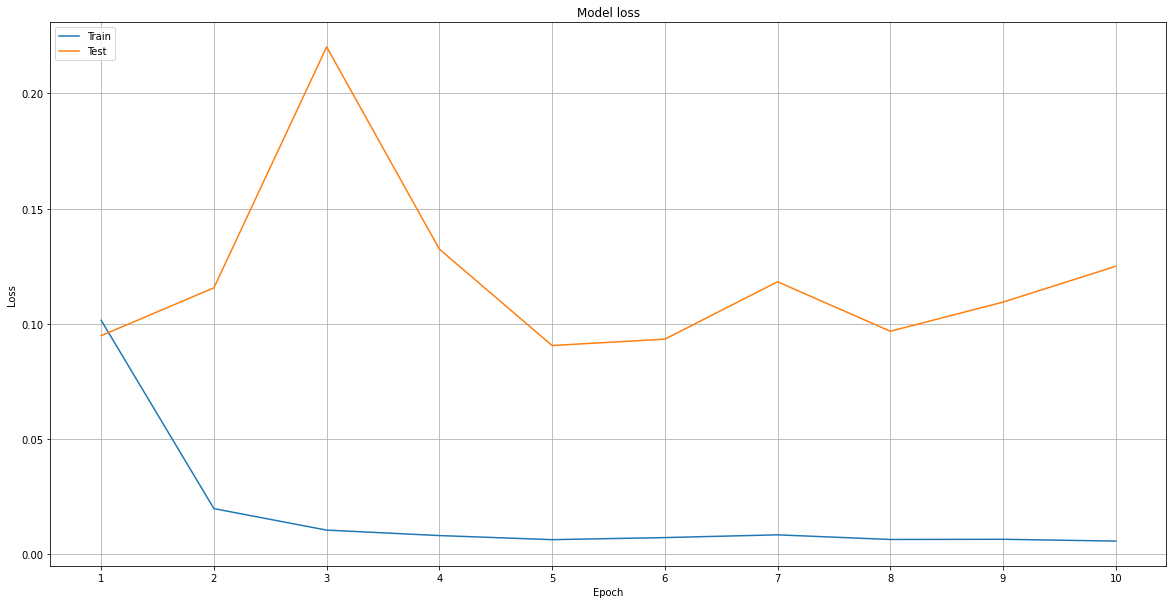

In [42]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [43]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 158.04
Mean Absolute Percentage Error (MAPE): 9.93 %
Median Absolute Percentage Error (MDAPE): 7.45 %


,MAE,MAPE,MDAPE
0,158.036474,9.931043,7.452725


In [44]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

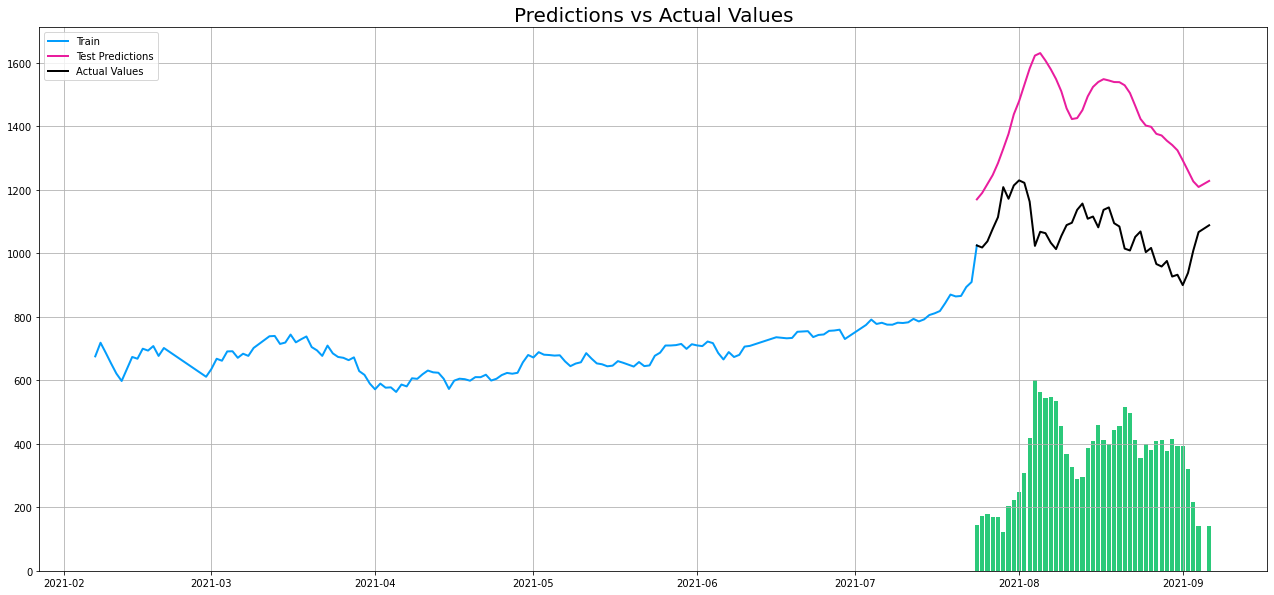

In [45]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 4-Day Shift

In [46]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['7D%Change', 'Volume', 'High', '7Dir', 'Dir', '6Dir', '3D%Change', '6D%Change', 'Low', 'SD', 'Daily%Change', '5Dir', '2Dir', 'Open', '2D%Change', '5D%Change', '4Dir', '4D%Change', 'SD_log', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,5Dir(t-4),2Dir(t-4),Open(t-4),2D%Change(t-4),5D%Change(t-4),4Dir(t-4),4D%Change(t-4),SD_log(t-4),3Dir(t-4),Close(t-4)
10,844.549988,1,65.0,418.0,209.0,-83.990148,824.0,274.666667,-91.782554,1615.0,...,1.0,0.0,831.000000,-3.474923,15.552777,1.0,12.362764,0.893449,1.0,849.440002
11,850.450012,2,21.0,86.0,43.0,-94.050992,439.0,146.333333,-94.827586,845.0,...,1.0,1.0,852.760010,5.327971,13.020185,1.0,4.701975,-0.062028,0.0,854.409973
12,844.989990,3,9.0,30.0,15.0,-86.153846,95.0,31.666667,-97.450425,448.0,...,1.0,0.0,843.390015,-0.522698,3.548848,0.0,-3.979457,-0.293989,1.0,845.000000
13,846.640015,4,157.0,166.0,83.0,647.619048,187.0,62.333333,141.538462,252.0,...,0.0,0.0,852.000000,-3.306375,-6.120321,1.0,1.845433,-0.574965,0.0,826.159973
14,880.799988,0,15.0,29.0,14.5,-60.526316,67.0,22.333333,-90.445860,224.0,...,1.0,0.0,837.799988,-0.053256,4.112475,0.0,-0.575675,-0.372200,0.0,844.549988


In [47]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,2Dir(t-4),Open(t-4),2D%Change(t-4),5D%Change(t-4),4Dir(t-4),4D%Change(t-4),SD_log(t-4),3Dir(t-4),Close(t-4),Prediction
242,932.570007,4,4.0,4.0,2.0,-80.000000,24.0,8.000000,-99.220273,537.0,...,0.0,1001.090027,-3.724847,-4.221964,0.0,-8.114098,0.591333,0.0,966.409973,932.570007
243,899.940002,0,9.0,15.0,7.5,28.571429,22.0,7.333333,125.000000,26.0,...,0.0,945.000000,-5.754011,-8.865224,0.0,-10.332468,0.248647,0.0,958.510010,899.940002
244,938.530029,1,7.0,16.0,8.0,16.666667,22.0,7.333333,0.000000,29.0,...,1.0,953.210022,0.991299,-8.697236,0.0,-2.770472,0.351218,0.0,975.989990,938.530029
246,1067.000000,3,1.0,1.0,0.5,-85.714286,8.0,2.666667,-88.888889,17.0,...,0.0,914.770020,-4.448814,-8.304575,0.0,-3.501616,0.267310,0.0,932.570007,1067.000000
249,1086.189941,2,1.0,1.0,0.5,100.000000,1.0,0.333333,-83.333333,7.0,...,1.0,965.659973,12.104139,3.368888,1.0,8.841110,0.705343,1.0,1008.869995,1086.189941


In [48]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(174, 43)
(50, 43)


In [49]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(167, 7, 43) (167,)
(43, 7, 43) (43,)
0.7858255406465309
0.7858255406465309


In [50]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.0799
Epoch 1: val_loss improved from inf to 0.18935, saving model to TSLA_Close_4shift_Baseline.h5
11/11 [==============================] - 7s 175ms/step - loss: 0.0799 - val_loss: 0.1893
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0156
Epoch 2: val_loss improved from 0.18935 to 0.10777, saving model to TSLA_Close_4shift_Baseline.h5
11/11 [==============================] - 1s 81ms/step - loss: 0.0156 - val_loss: 0.1078
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.0119
Epoch 3: val_loss did not improve from 0.10777
11/11 [==============================] - 1s 77ms/step - loss: 0.0119 - val_loss: 0.2490
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0104
Epoch 4: val_loss did not improve from 0.10777
11/11 [==============================] - 1s 77ms/step - loss: 0.0104 - val_loss: 0.1931
Epoch 5/100
11/11 [==============================] - ETA:

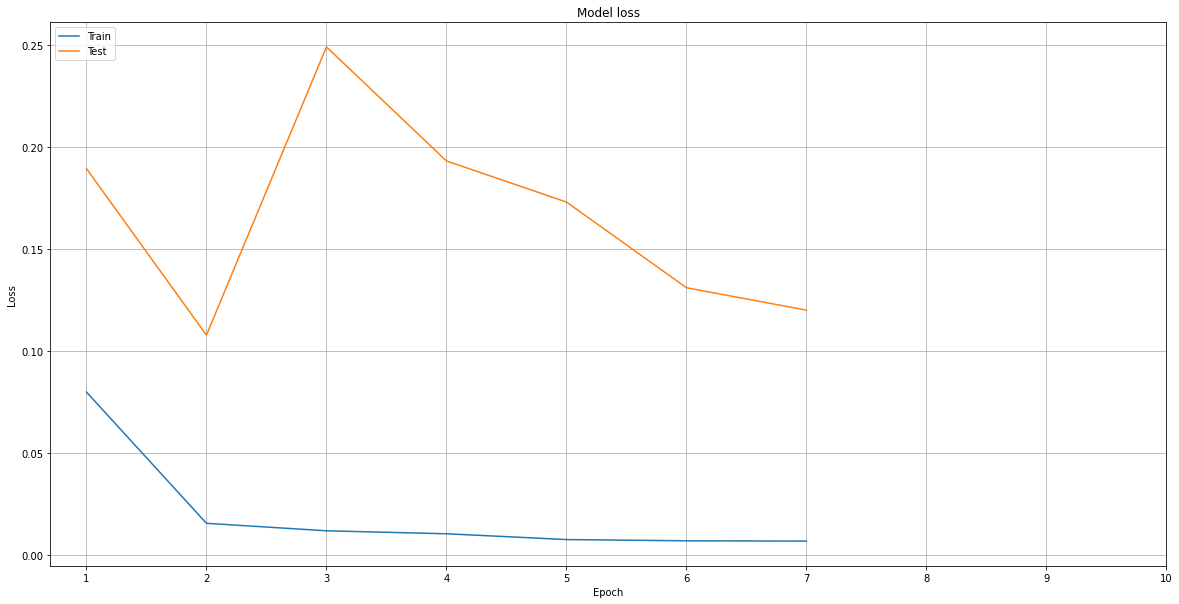

In [52]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [53]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 171.7
Mean Absolute Percentage Error (MAPE): 10.79 %
Median Absolute Percentage Error (MDAPE): 9.25 %


,MAE,MAPE,MDAPE
0,171.695031,10.793295,9.248959


In [54]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

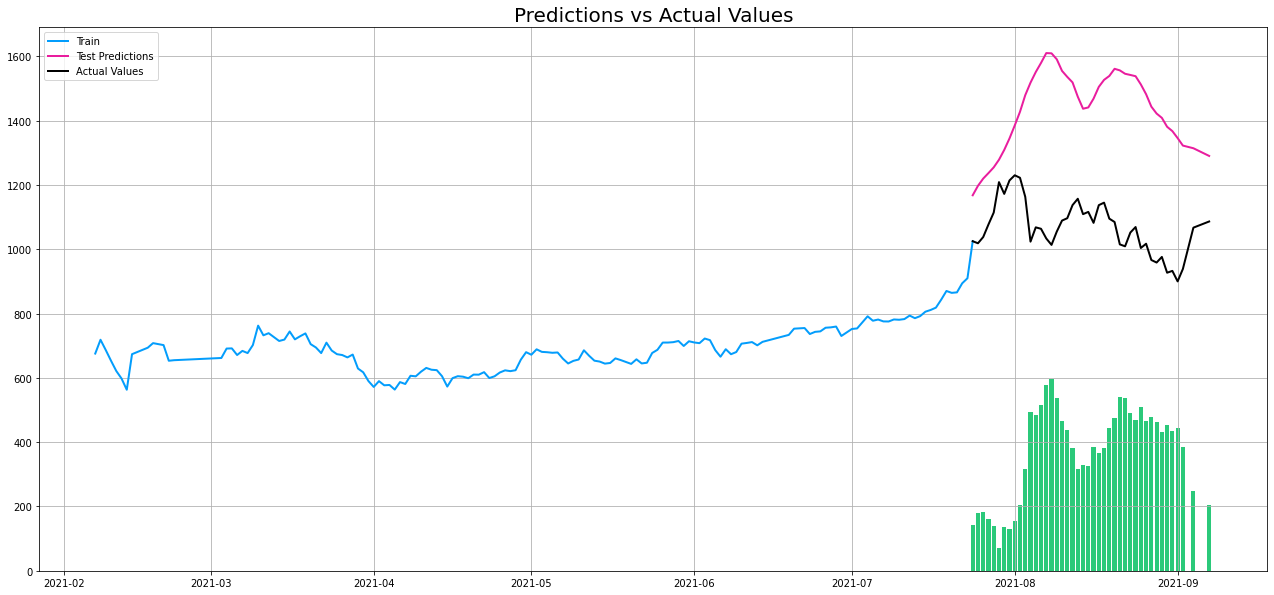

In [55]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 7-Day Shift

In [56]:
bdep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['7D%Change', 'Volume', 'High', '7Dir', 'Dir', '6Dir', '3D%Change', '6D%Change', 'Low', 'SD', 'Daily%Change', '5Dir', '2Dir', 'Open', '2D%Change', '5D%Change', '4Dir', '4D%Change', 'SD_log', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,5Dir(t-7),2Dir(t-7),Open(t-7),2D%Change(t-7),5D%Change(t-7),4Dir(t-7),4D%Change(t-7),SD_log(t-7),3Dir(t-7),Close(t-7)
13,846.640015,4,65.0,418.0,209.0,-83.990148,824.0,274.666667,-91.782554,1615.0,...,1.0,0.0,831.000000,-3.474923,15.552777,1.0,12.362764,0.893449,1.0,849.440002
14,880.799988,0,157.0,166.0,83.0,647.619048,187.0,62.333333,141.538462,252.0,...,1.0,1.0,852.760010,5.327971,13.020185,1.0,4.701975,-0.062028,0.0,854.409973
15,883.090027,1,38.0,195.0,97.5,322.222222,204.0,68.000000,80.952381,225.0,...,1.0,0.0,843.390015,-0.522698,3.548848,0.0,-3.979457,-0.293989,1.0,845.000000
16,864.159973,2,14.0,52.0,26.0,-91.082803,209.0,69.666667,55.555556,218.0,...,0.0,0.0,852.000000,-3.306375,-6.120321,1.0,1.845433,-0.574965,0.0,826.159973
17,835.429993,3,15.0,29.0,14.5,-60.526316,67.0,22.333333,-90.445860,224.0,...,1.0,0.0,837.799988,-0.053256,4.112475,0.0,-0.575675,-0.372200,0.0,844.549988


In [57]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,2Dir(t-7),Open(t-7),2D%Change(t-7),5D%Change(t-7),4Dir(t-7),4D%Change(t-7),SD_log(t-7),3Dir(t-7),Close(t-7),Prediction
245,1008.869995,2,6.0,13.0,6.5,50.000000,17.0,5.666667,100.000000,17.0,...,0.0,1001.090027,-3.724847,-4.221964,0.0,-8.114098,0.591333,0.0,966.409973,1008.869995
246,1067.000000,3,9.0,15.0,7.5,28.571429,22.0,7.333333,125.000000,26.0,...,0.0,945.000000,-5.754011,-8.865224,0.0,-10.332468,0.248647,0.0,958.510010,1067.000000
247,1093.939941,0,1.0,2.0,1.0,100.000000,2.0,0.666667,-85.714286,9.0,...,1.0,953.210022,0.991299,-8.697236,0.0,-2.770472,0.351218,0.0,975.989990,1093.939941
248,1088.469971,1,3.0,4.0,2.0,200.000000,5.0,1.666667,100.000000,5.0,...,0.0,994.500000,-3.295743,-7.658897,0.0,-8.860117,-0.213415,0.0,926.919983,1088.469971
249,1086.189941,2,6.0,9.0,4.5,500.000000,10.0,3.333333,500.000000,11.0,...,0.0,914.770020,-4.448814,-8.304575,0.0,-3.501616,0.267310,0.0,932.570007,1086.189941


In [58]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(175, 43)
(50, 43)


In [59]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(168, 7, 43) (168,)
(43, 7, 43) (43,)
0.6523817284751647
0.6523817284751647


In [60]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.0648
Epoch 1: val_loss improved from inf to 0.13397, saving model to TSLA_Close_7shift_Baseline.h5
11/11 [==============================] - 6s 176ms/step - loss: 0.0648 - val_loss: 0.1340
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0202
Epoch 2: val_loss improved from 0.13397 to 0.07168, saving model to TSLA_Close_7shift_Baseline.h5
11/11 [==============================] - 1s 85ms/step - loss: 0.0202 - val_loss: 0.0717
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.0145
Epoch 3: val_loss did not improve from 0.07168
11/11 [==============================] - 1s 71ms/step - loss: 0.0145 - val_loss: 0.1109
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0098
Epoch 4: val_loss did not improve from 0.07168
11/11 [==============================] - 1s 72ms/step - loss: 0.0098 - val_loss: 0.0866
Epoch 5/100
11/11 [==============================] - ETA:

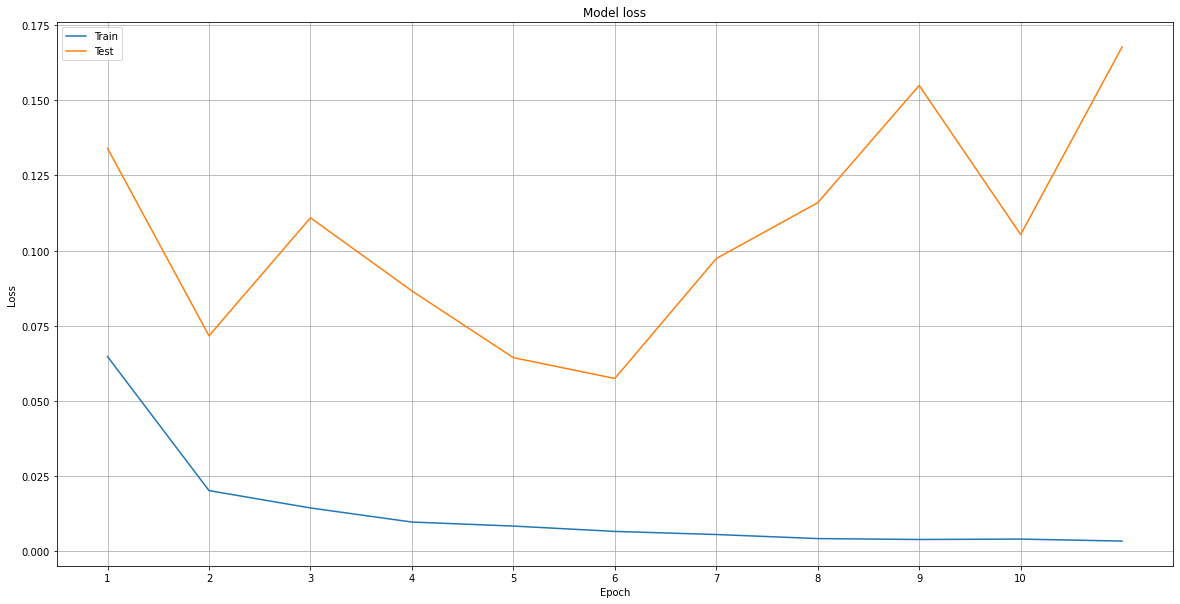

In [62]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [63]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 124.16
Mean Absolute Percentage Error (MAPE): 9.36 %
Median Absolute Percentage Error (MDAPE): 8.04 %


,MAE,MAPE,MDAPE
0,124.162261,9.359265,8.037322


In [64]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

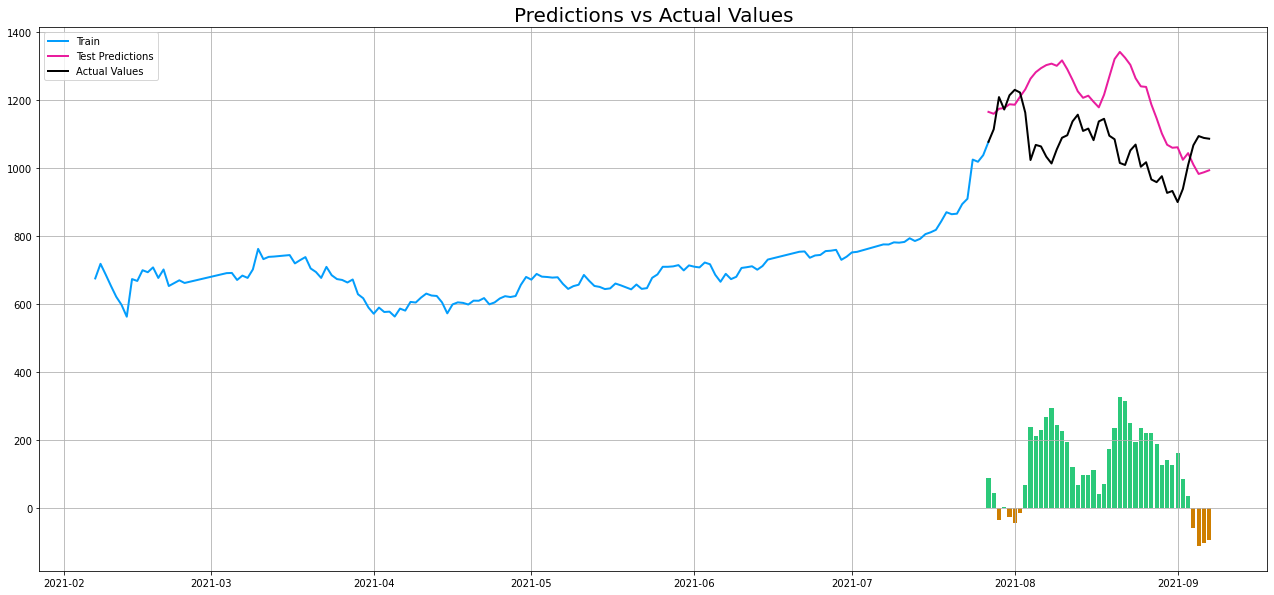

In [65]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## Overall Results

In [66]:
results_df =pd.DataFrame.from_dict(results_dict).transpose().reset_index()
results_df['ticker'] = results_df['index'].str.split('_').str[0]
results_df['shift'] = results_df['index'].str.split('_').str[1]
results_df['metric'] = results_df['index'].str.split('_').str[2]
results_df['scenario'] = results_df['index'].str.split('_').str[3]
results_df['scenario'].fillna(value = 'sentiment', inplace = True)
results_df['results_%'] = results_df[0]
results_df.drop(['index', 0], axis = 1, inplace = True)
results_df.sort_values(['metric', 'shift','scenario'], inplace = True)
results_df = results_df.pivot(index = ['shift', 'metric'], columns = 'scenario', values = 'results_%').reset_index()
results_df

scenario,shift,metric,baseline,sentiment
0,1dayshift,MAE,158.036474,79.510290
1,1dayshift,MAPE,9.931043,7.350353
2,1dayshift,MDAPE,7.452725,6.840483
3,4dayshift,MAE,171.695031,95.982795
4,4dayshift,MAPE,10.793295,8.592865
5,4dayshift,MDAPE,9.248959,6.208880
6,7dayshift,MAE,124.162261,92.590979
7,7dayshift,MAPE,9.359265,8.326711
8,7dayshift,MDAPE,8.037322,5.825877


In [67]:
results_df.to_csv('{}_LSTM.csv'.format(ticker), index = False)